In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cine_seg.npz


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
data = np.load('/kaggle/input/cine_seg.npz',allow_pickle=True)

(256, 256) (256, 256)


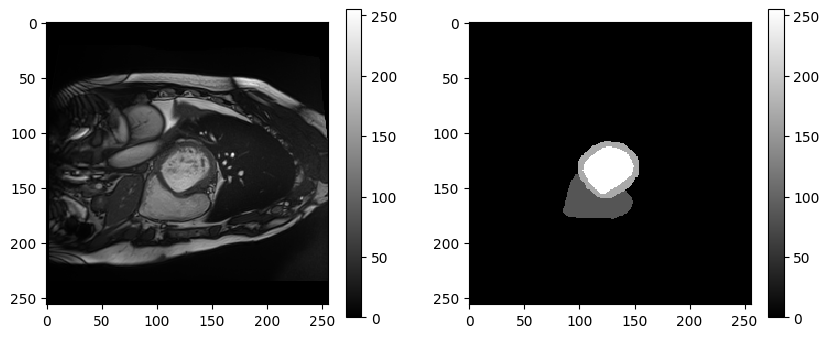

In [3]:
images = []
labels = []
for i in range (len(data.files)):
    images.append(data[data.files[i]][0])
    labels.append(data[data.files[i]][1])
# print(len(images),len(labels))
img = images[1]
gt = labels[1]
print(img.shape,gt.shape)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(gt)
plt.colorbar()
plt.show()
plt.close('all')

In [4]:
images = np.array(images)
labels = np.array(labels)

In [5]:
images = images.astype(np.float32) / 255.0

In [6]:
unique_labels = np.unique(labels)
print(f'Unique label values before clipping: {unique_labels}')

Unique label values before clipping: [  0  85 170 255]


In [8]:
label_mapping = {0: 0, 85: 1, 170: 2, 255: 3}


mapped_labels = np.vectorize(label_mapping.get)(labels)

unique_labels = np.unique(mapped_labels)
print(f'Unique label values after mapping: {unique_labels}')

Unique label values after mapping: [0 1 2 3]


In [9]:
train_images, temp_images, train_labels, temp_labels = train_test_split(images, mapped_labels, test_size=0.3, random_state=42)
val_images, test_images, val_labels, test_labels = train_test_split(temp_images, temp_labels, test_size=0.6667, random_state=42)


train_images = torch.tensor(train_images, dtype=torch.float32).unsqueeze(1)
train_labels = torch.tensor(train_labels, dtype=torch.long)
val_images = torch.tensor(val_images, dtype=torch.float32).unsqueeze(1)
val_labels = torch.tensor(val_labels, dtype=torch.long)
test_images = torch.tensor(test_images, dtype=torch.float32).unsqueeze(1)
test_labels = torch.tensor(test_labels, dtype=torch.long)
print(train_images.shape, train_labels.shape)
print(val_images.shape, val_labels.shape)
print(test_images.shape, test_labels.shape)

torch.Size([1258, 1, 256, 256]) torch.Size([1258, 256, 256])
torch.Size([179, 1, 256, 256]) torch.Size([179, 256, 256])
torch.Size([361, 1, 256, 256]) torch.Size([361, 256, 256])


In [10]:
train_dataset = TensorDataset(train_images, train_labels)
val_dataset = TensorDataset(val_images, val_labels)
test_dataset = TensorDataset(test_images, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [11]:
import torch.nn.functional as F
class UNet(nn.Module):
    def __init__(self, num_classes=4):
        super(UNet, self).__init__()
        

        self.enc1 = self.double_conv(1,16)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = self.double_conv(16, 32)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = self.double_conv(32, 64)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = self.double_conv(64,128)
        self.pool4 = nn.MaxPool2d(2)


        self.bottleneck = self.double_conv(128, 256)


        self.upconv4 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec4 = self.double_conv(256, 128)
        self.upconv3 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec3 = self.double_conv(128,64)
        self.upconv2 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec2 = self.double_conv(64, 32)
        self.upconv1 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.dec1 = self.double_conv(32, 16)

        self.final = nn.Conv2d(16, num_classes, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    def center_crop_and_concat(self, x1, x2):
        H1, W1 = x1.shape[2], x1.shape[3]
        H2, W2 = x2.shape[2], x2.shape[3]
        if H1 != H2 or W1 != W2:
            x1 = F.pad(x1, [
                (W2-W1) // 2, # left
                (W2-W1) // 2, # right
                (H2-H1) // 2, # top
                (H2-H1) // 2  # bottom
            ])
        return torch.cat([x1, x2], dim=1)
    def forward(self, x):

        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        enc4 = self.enc4(self.pool3(enc3))
        

        bottleneck = self.bottleneck(self.pool4(enc4))
        
        dec4 = self.upconv4(bottleneck)
        dec4 = self.center_crop_and_concat(enc4, dec4)
        dec4 = self.dec4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = self.center_crop_and_concat(enc3, dec3)
        dec3 = self.dec3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = self.center_crop_and_concat(enc2, dec2)
        dec2 = self.dec2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = self.center_crop_and_concat(enc1, dec1)
        dec1 = self.dec1(dec1)
        
        return self.final(dec1)



In [16]:
class DiceLoss(nn.Module):
    def __init__(self, epsilon=1e-6):
        super(DiceLoss, self).__init__()
        self.epsilon = epsilon

    def forward(self, outputs, targets):
        # 将预测结果通过softmax转换为概率分布
        outputs = torch.softmax(outputs, dim=1)
        
        # 将目标标签转换为one-hot编码
        num_classes = outputs.size(1)
        targets_one_hot = torch.eye(num_classes, device=targets.device)[targets]
        targets_one_hot = targets_one_hot.permute(0, 3, 1, 2).contiguous()

        # 忽略背景类，假设背景类是第0类
        outputs = outputs[:, 1:, :, :]
        targets_one_hot = targets_one_hot[:, 1:, :, :]

        # 计算交集和并集
        intersection = (outputs * targets_one_hot).sum(dim=(2, 3))
        union = outputs.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3))

        # 计算Dice系数
        dice = (2. * intersection + self.epsilon) / (union + self.epsilon)

        # 取Dice系数的均值作为损失值
        return 1 - dice.mean()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
criterion = DiceLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [17]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)

        train_loss = train_loss / len(train_loader.dataset)
        train_loss_history.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_loss_history.append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    return train_loss_history, val_loss_history


train_loss_history, val_loss_history = train_model(model, train_loader, val_loader, criterion, optimizer)


Epoch 1/10, Train Loss: 0.9368, Val Loss: 0.8878
Epoch 2/10, Train Loss: 0.8624, Val Loss: 0.7854
Epoch 3/10, Train Loss: 0.8010, Val Loss: 0.7676
Epoch 4/10, Train Loss: 0.7359, Val Loss: 0.6859
Epoch 5/10, Train Loss: 0.7534, Val Loss: 0.7434
Epoch 6/10, Train Loss: 0.7037, Val Loss: 0.6906
Epoch 7/10, Train Loss: 0.6432, Val Loss: 0.6463
Epoch 8/10, Train Loss: 0.6438, Val Loss: 0.5949
Epoch 9/10, Train Loss: 0.6398, Val Loss: 0.6092
Epoch 10/10, Train Loss: 0.8037, Val Loss: 0.9062


In [ ]:
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [ ]:
import matplotlib.pyplot as plt

def show_example_segmentation(model, test_loader, device):
    model.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            if i >= 5:  
                break
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow(images[0].cpu().squeeze(), cmap='gray')
            axes[0].set_title('Original Image')
            axes[1].imshow(labels[0].cpu().squeeze(), cmap='gray')
            axes[1].set_title('Ground Truth')
            axes[2].imshow(preds[0].cpu().squeeze(), cmap='gray')
            axes[2].set_title('Predicted Segmentation')
            plt.show()

show_example_segmentation(model, test_loader, device)


In [ ]:
def dice_coefficient(pred, target, epsilon=1e-6):
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2. * intersection + epsilon) / (union + epsilon)
    return dice.item()

def calculate_dice_for_classes(preds, labels):
    dice_scores = {'LV': [], 'RV': [], 'MYO': []}
    
    for pred, label in zip(preds, labels):
        for class_idx, class_name in zip([1, 2, 3], ['LV', 'RV', 'MYO']):
            pred_class = (pred == class_idx).float()
            label_class = (label == class_idx).float()
            dice = dice_coefficient(pred_class, label_class)
            dice_scores[class_name].append(dice)
    
    return dice_scores


In [ ]:
import numpy as np

def evaluate_model(model, test_loader, device):
    model.eval()
    dice_scores = {'LV': [], 'RV': [], 'MYO': []}

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            batch_dice_scores = calculate_dice_for_classes(preds.cpu(), labels.cpu())
            for key in dice_scores:
                dice_scores[key].extend(batch_dice_scores[key])

    mean_dice = {key: np.mean(dice_scores[key]) for key in dice_scores}
    std_dice = {key: np.std(dice_scores[key]) for key in dice_scores}

    return mean_dice, std_dice

mean_dice, std_dice = evaluate_model(model, test_loader, device)

print("Dice Coefficient Mean and Standard Deviation:")
for key in mean_dice:
    print(f"{key} - Mean: {mean_dice[key]:.4f}, Std: {std_dice[key]:.4f}")


In [ ]:
for key in mean_dice:
    print(f"Segmentation Performance for {key}:")
    print(f"Mean Dice Coefficient: {mean_dice[key]:.4f}")
    print(f"Standard Deviation of Dice Coefficient: {std_dice[key]:.4f}")